# Age Calculation of $U/Th$ disequilibrium ages

This script is used to calculate U/Th ages using the same method as is used in an Excel Spreadsheet by Hai Cheng. It takes MC-ICP-MS output data, i.e. tables of U and Th counts and iteratively calculates ages that represent the best fit for the determined $\frac{^{230}Th}{^{238}U}_A$ activity ratios

## 1) package dependencies and basic functions

Several standard packages are required for basic maths, data handling and plotting functionality:

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Sample_Spike:
    
    '''
    the init method holds default values for the chemistry blank
    at some point it might be actually useful to use the actual chemistry blank values here
    
    also included are defined values for the spike.
    '''
    
    def __init__(self,
                 smpl_weight,
                 spk_weight):
        
        
        #sample input
        self.smpl_weight = smpl_weight # [g]
        self.smpl_weight_e = 0.00001
        
        
        #spike input
        self.spk_weight = spk_weight # [g]
        self.spk_weight_e = 0.00001
        
        self.spk_U233 = 0.78764 # [pmol/g]
        self.spk_U233_e = 0.0002

        self.spk_Th229 = 0.21686 # [pmol/g]
        self.spk_Th229_e = 0.0001
        
        # spike ratios U
        self.spk_U238_U233 = 0.016802154
        self.spk_U235_U233 = 0.105321392
        self.spk_U234_U233 = 0.003195127
        
        # spike ratios Th
        self.spk_Th230_Th229 = 0.0000625
        self.spk_Th232_Th229 = 0.00065
        self.spk_Th232_Th229_e = 0.00005
        
        
        # chemistry blank values
        self.ch_blank_U238 = 0.02 # [pmol]
        self.ch_blank_U238_e = 0.02
        self.ch_blank_Th232 = 0.0005 # [pmol]
        self.ch_blank_Th232_e = 0.0005
        self.ch_blank_Th230 = 0.0001 # [fmol]
        self.ch_blank_Th230_e = 0.0005

        self.Th_loaded = 0.8
        
        # exponential for SEM correction
        self.SEM_corr = 1 
        
        # frac. correction for Th, ‰ per AMU
        self.Th_corr = 1 

In [3]:
###########################################################################################################################
###################################################   U   #################################################################
###########################################################################################################################

class U_measurement(Sample_Spike):
    
    def __init__(self,
                 smpl_weight,
                 spk_weight,
                 mean_U235_U233,
                 mean_U235_U233_e,
                 mean_U234_U235,
                 mean_U234_U235_e,
                 mean_U233,
                 n_U233,
                 n_U234_U235,
                 bg_U233,
                 bg_U234,
                 bg_U235):
        
        super().__init__(smpl_weight, spk_weight)
        
        # ratio means ... this will later be the output of the standard deviation filters
        # this is the green fields in Hai's template
        
        self.mean_U235_U233 = mean_U235_U233
        self.mean_U235_U233_e = mean_U235_U233_e
        self.mean_U235_U233_re = self.mean_U235_U233_e / self.mean_U235_U233 * 1000

        self.mean_U234_U235 = mean_U234_U235
        self.mean_U234_U235_e = mean_U234_U235_e
        
        self.mean_U233 = mean_U233 # I14
        self.mean_U233_e = self.mean_U233 * 0.05 # J14
        
        self.n_U233 = n_U233
        self.n_U234_U235 = n_U234_U235
        
        # background counts [cps]
        # this is the yellow fields

        self.bg_U233 = bg_U233
        self.bg_U234 = bg_U234
        self.bg_U235 = bg_U235

        # some static variables
        
        self.fil_blk_238U = 0.0001 # I15
        self.fil_blk_238U_e = 0.1 # J15
        
        self.r_238U_U235 = 137.82 # I12
        
        ratios = self.mean_U235_U233 * self.mean_U234_U235 * self.mean_U233
        self.wt_U234_U235 = self.mean_U234_U235 * (1 - self.bg_U234 / ratios) # D16, D29
        self.wt_U234_U235_e = self.mean_U234_U235_e  # E16, E29
        self.wt_U234_U235_re = self.wt_U234_U235_e / self.wt_U234_U235 * 1000
        
        # counting times + errors
        
        self.ct_time_U233 = 0.131 * 3 # K11
        self.ct_time_U235 = 0.131 # K12
        self.ct_time_U234 = 1.049 # K13
        
        self.ce233 = self.counting_error(self.mean_U233 * self.n_U233 * self.ct_time_U233) # I16
        self.ce234 = self.counting_error(self.csum_234()) # I17
        self.ce235 = self.counting_error(self.mean_U233 * self.n_U233 * self.ct_time_U235 * self.mean_U235_U233) # I18
        
        
    def counting_error(self, counts):
        ce = 2000 / counts ** 0.5
        return ce
    
    
    def r_U234_U233(self):
        # D28
        r = (self.wt_U234_U235 * self.mean_U235_U233) ** self.SEM_corr
        return r
    
    
    def r_U234_U233_e(self):
        # E28
        r_re = max([(self.mean_U235_U233_re**2 + self.wt_U234_U235_re**2)**0.5, 
                np.sqrt(self.ce234**2 + 2*self.ce233**2 + 2/9*self.ce233**2)])
        r_e = self.r_U234_U233() * r_re / 1000
        return r_e
    
    
    def csum_234(self):
        # I13
        csum = self.r_U234_U233() * self.mean_U233 * self.ct_time_U234 * self.n_U233
        return csum
    
#     def r_U234_U235_spkcorr(self):
#         # D31
#         r = self.wt_U234_U235 * (1-self.spk_U234_U233/r_U234_U233())
#         # F31
#         r_re = np.sqrt()
        
#         return r

###########################################################################################################################
###################################################   Th   ################################################################
###########################################################################################################################


class Th_measurement(Sample_Spike):
    
    def __init__(self,
                 smpl_weight,
                 spk_weight,
                 mean_Th230_Th229,
                 mean_Th230_Th229_e, 
                 mean_Th232_Th229,
                 mean_Th232_Th229_e, 
                 mean_Th229,
                 n_Th229,
                 bg_Th230):
        
        super().__init__(smpl_weight, spk_weight)
        
        #ratio means ... as above, take these from filter function
        self.mean_Th230_Th229 = mean_Th230_Th229
        self.mean_Th230_Th229_e = mean_Th230_Th229_e
        self.mean_Th230_Th229_re = self.mean_Th230_Th229_e / self.mean_Th230_Th229 * 1000

        self.mean_Th232_Th229 = mean_Th232_Th229
        self.mean_Th232_Th229_e = mean_Th232_Th229_e
        self.mean_Th232_Th229_re = mean_Th232_Th229_e / mean_Th232_Th229 * 1000

        self.mean_Th229 = mean_Th229
        self.n_Th229 = n_Th229
        
        self.bg_Th230 = bg_Th230 # aka darknoise(cpm); attention! cps * 60 for cpm from wash file
        self.bg_Th230_re = 200
        self.bg_Th230_e = self.bg_Th230 * self.bg_Th230_re / 1000
        
        self.run_duration = 60 # [min]
        
        ############################################################################################
        # abundance sensitivity
        # @1 amu
        self.Th_AS1 = 0.0000000001
        self.Th_AS1_re = 250
        self.Th_AS1_e = self.Th_AS1_re / 1000 * self.Th_AS1
        # @2 amu
        self.Th_AS2 = self.Th_AS1 / 2.5
        self.Th_AS2_re = 250
        self.Th_AS2_e = self.Th_AS2_re / 1000 * self.Th_AS2

        ############################################################################################
        # counting times

        self.cr_Th229 = self.mean_Th229
        self.cr_Th229_e = 10

        self.cr_Th230 = self.cr_Th229 * self.mean_Th230_Th229
        self.cr_Th230_e = 10

        self.cr_Th232 = self.cr_Th229 * self.mean_Th232_Th229
        self.cr_Th232_e = 10

        self.mv_Th232 = self.cr_Th229 * self.mean_Th232_Th229 / 62500

## 1.1) Initialising U and Th classes

the classes constitute the basis of age calculation. We require the output of the raw data filters and generate the input variables for the actual [U_Th_inverse class](#2-Basic-age-calculation)

In [4]:
U_input = {'mean_U235_U233' : 6.20290913753549,
           'mean_U235_U233_e' : 0.00637449891487154,
           'mean_U234_U235' : 0.014108989195374,
           'mean_U234_U235_e' : 0.0000145097087932848,
           'mean_U233' : 52142.888246515,
           'n_U233' : 618,
           'n_U234_U235' : 571,
           'bg_U233' : 20,
           'bg_U234' : 1.7,
           'bg_U235' : 176}

Th_input = {'mean_Th230_Th229' : 0.0284092340767724,
            'mean_Th230_Th229_e' : 0.0000313298040608886,
            'mean_Th232_Th229' : 264.576975166979,
            'mean_Th232_Th229_e' : 5.29716937744296,
            'mean_Th229' : 293090.768637619,
            'n_Th229' : 564,
            'bg_Th230' : 54}

In [5]:
Sm_Sp = Sample_Spike(0.08129, 0.63262)
U = U_measurement(0.08129, 0.63262, **U_input)
Th = Th_measurement(0.08129, 0.63262, **Th_input)

U.spk_U234_U233

0.003195127

## 2 Basic age calculation

The fundamental formulae on which the age calculation is based upon. Input variables, that are ultimately derived from the measurements are:

$\frac{^{234}U}{^{238}U}_A$
__= r_U234_U238__
    
$\frac{^{230}Th}{^{238}U}_A$
__= r_Th230_U238__
     
also absolute errors are required

__r_U234_U238_e__ <br>
__r_Th230_U238_e__

***
for the correction of $\frac{^{230}Th}{^{232}Th}_init$, further inputs of molar concentrations are required. They have to be parsed as a dictionary (corr_input):

corr_input = {<br>
'c_Th230' : $[^{230}Th]$ pmol/g,<br>
'c_Th230_e' : $[^{230}Th]$ absolute error in pmol/g,<br>
'c_Th232' : $[^{232}Th]$ pmol/g,<br>
'c_Th232_e' : $[^{232}Th]$ absolute error in pmol/g,<br>
'cf_U238' : $[^{238}U]$ filament blank corr,<br>
'cf_U238_e' : $[^{238}U]$ filament blank corr absolute error<br>
}

***
Moreover, the Excel Goal Seek Algorithm is implemented in order to be as consistent as possible. Max iterations and stepsize is adjusted according to the spredsheet template. 

This function is taken from a github repository at https://github.com/DrTol/GoalSeek_Python

In [6]:
class U_Th_inverse:
    
    def __init__(self,
                 r_U234_U238,
                 r_U234_U238_e,
                 r_Th230_U238,
                 r_Th230_U238_e,
                 corr_input):
        
        self.l_230 = 0.0000091577*1.0014
        self.l_232 = 0.000000000049475
        self.l_234 = 0.0000028263*0.9985
        self.l_238 = 0.000000000155125
        
        self.Th230_Th232_init = 0.0000044 # default value for 230/232 inital correction. i.e. bulk earth
        self.Th230_Th232_init_e = self.Th230_Th232_init/2 # error for default 230/232 initial
        
        self.r_U234_U238 = r_U234_U238
        self.r_U234_U238_e = r_U234_U238_e
        
        self.r_Th230_U238 = r_Th230_U238
        self.r_Th230_U238_e = r_Th230_U238_e
        
        self.corr_input = corr_input
        
        self.startage = 1000
        
    
    def GS(self, fun, goal, x0, fTol=0.00000000001, MaxIter=1000):
        # Goal Seek function of Excel
        #   via use of Line Search and Bisection Methods

        # Inputs
        #   fun     : Function to be evaluated
        #   goal    : Expected result/output
        #   x0      : Initial estimate/Starting point

        # Initial check
        if fun(x0)==goal:
            print('Exact solution found')
            return x0

        # Line Search Method
        step_sizes=np.logspace(-1,4,6)
        scopes=np.logspace(1,5,5)

        vFun=np.vectorize(fun)

        for scope in scopes:
            break_nested=False
            for step_size in step_sizes:

                cApos=np.linspace(x0,x0+step_size*scope,int(scope))
                cAneg=np.linspace(x0,x0-step_size*scope,int(scope))

                cA=np.concatenate((cAneg[::-1],cApos[1:]),axis=0)

                fA=vFun(cA)-goal

                if np.any(np.diff(np.sign(fA))):

                    index_lb=np.nonzero(np.diff(np.sign(fA)))

                    if len(index_lb[0])==1:

                        index_ub=index_lb+np.array([1])

                        x_lb=np.asscalar(np.array(cA)[index_lb][0])
                        x_ub=np.asscalar(np.array(cA)[index_ub][0])
                        break_nested=True
                        break
                    else: # Two or more roots possible

                        index_ub=index_lb+np.array([1])

                        print('Other solution possible at around, x0 = ', np.array(cA)[index_lb[0][1]])

                        x_lb=np.asscalar(np.array(cA)[index_lb[0][0]])
                        x_ub=np.asscalar(np.array(cA)[index_ub[0][0]])
                        break_nested=True
                        break

            if break_nested:
                break
        if not x_lb or not x_ub:
            print('No Solution Found')
            return

        # Bisection Method
        iter_num=0
        error=10

        while iter_num<MaxIter and fTol<error:

            x_m=(x_lb+x_ub)/2
            f_m=fun(x_m)-goal

            error=abs(f_m)

            if (fun(x_lb)-goal)*(f_m)<0:
                x_ub=x_m
            elif (fun(x_ub)-goal)*(f_m)<0:
                x_lb=x_m
            elif f_m==0:
                print('Exact solution found')
                return x_m
                
            self.startage = x_m
            iter_num+=1

        return x_m
    
    
    def d234U(self):
        '''calculate the delta234U parameter from a concentration ratio 234/238'''
        
        l = self.l_234 / self.l_238 / 10**6
        delta = (self.r_U234_U238 * l - 1) * 1000
        delta_e = (self.r_U234_U238_e * l) * 1000
        
        return (delta, delta_e)
    
    
    def d234U_i(self, age, age_e):
        '''
        back-calculate the d234U - initial based on a given age.
        The age to use as an corr_input here is typically the output of iter_age().age[0]
        '''
        delta =  self.d234U()[0] * np.e ** (self.l_234 * age)
        
        f1 = (self.d234U()[1] * np.e ** (self.l_234 * age))**2
        f2 = (self.d234U()[0] * np.e ** (self.l_234*(age+age_e)) - delta)**2
        delta_e = np.sqrt(f1 + f2)
        
        return delta, delta_e
    
    
    def delta_to_A(self, delta, delta_e = 0):
        '''
        convert d234U_initial to 234/238 activity ratio
        '''
        
        l = self.l_234 / self.l_238 / 10**6
        A =  ((delta / 1000) + 1) / l
        A_e = (delta_e / 1000) / l
          
        return A, A_e
    
    
    def A_Th230_U238(self):
        A_Th230_U238 = self.r_Th230_U238 * self.l_230 / self.l_238
        A_Th230_U238_e = self.r_Th230_U238_e * self.l_230 / self.l_238
        
        return (A_Th230_U238, A_Th230_U238_e)
    
    
    def A_Th230_Th232_now(self):
        A = self.Th230_Th232_init * np.e**(-self.l_230 * self.startage)
        A_e = A * self.Th230_Th232_init_e / self.Th230_Th232_init
        
        A_max = (self.Th230_Th232_init + self.Th230_Th232_init_e) * np.e**(-self.l_230 * self.startage) # Cell C62
        
        return A, A_e, A_max
        
        
    def A_Th230_U238_corr(self,
                          c_Th230,
                          c_Th230_e,
                          c_Th232,
                          c_Th232_e,
                          cf_U238,
                          cf_U238_e):
        
        A_Th230_U238 = (c_Th230 - self.A_Th230_Th232_now()[0] * c_Th232) *self.l_230 / (cf_U238*1000*self.l_238)
        A_Th230_U238_max = (c_Th230 - self.A_Th230_Th232_now()[2] * c_Th232) *self.l_230 / (cf_U238*1000*self.l_238)
        
        #error calculation (this seems unnecessarily complex... maybe we can simplify this code)
        t2 = (self.A_Th230_Th232_now()[0] * c_Th232) * np.sqrt((self.A_Th230_Th232_now()[1]/self.A_Th230_Th232_now()[0])**2 + (c_Th232_e/c_Th232)**2)
        t3 = c_Th230-self.A_Th230_Th232_now()[0]*c_Th232
        t1 = np.sqrt(t2**2 + c_Th230_e**2) / t3
        tn = cf_U238_e/cf_U238
        
        A_Th230_U238_e = A_Th230_U238 * np.sqrt(t1**2 + tn**2)
        
        return A_Th230_U238, A_Th230_U238_e, A_Th230_U238_max
    
    
    ######################################################################################################################
    ######################################################################################################################
    ###################################################################################################################### 
    
    
        '''
        CALCULATE RESIDUES FROM AGES
        age calculation formula for goal seek algorithm to 0
        taken from Hai Cheng's Excel Spreadsheet
        '''
        
        
    def residue_1(self, age):
        # uncorrected age
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = (self.d234U()[0] / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = self.A_Th230_U238()[0] - ( f1 + f2 * f3 )
        return res
    
    
    def residue_2(self, age):
        # AGE with [Th/U] max - AGE max
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = (self.d234U()[0] / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = (self.A_Th230_U238()[0]+self.A_Th230_U238()[1]) - ( f1 + f2 * f3 )
        return res
    
    
    def residue_3(self, age):
        # AGE with [Th/U] max - AGE min
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = (self.d234U()[0] / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = self.A_Th230_U238()[0]-self.A_Th230_U238()[1] - ( f1 + f2 * f3 )
        return res
    
    
    def residue_4(self, age):
        # AGE with d234U max - AGE min
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = ((self.d234U()[0]+self.d234U()[1]) / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = self.A_Th230_U238()[0] - ( f1 + f2 * f3 )
        return res
    
    
    def residue_5(self, age):
        # AGE with d234U min - AGE max
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = ((self.d234U()[0]-self.d234U()[1]) / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = self.A_Th230_U238()[0] - ( f1 + f2 * f3 )
        return res    
    
    
    def iter_age(self, x0 = 1000, goal = 0):
        '''
        iterate over multiple ages to approximate residue function to 0;
        the x0 parameter is the starting value of the age - this value is arbitrary
        
        returns: pandas DataFrame with uncorrected ages as in template:
        Uncorrected age (Years) = age1
        AGE with [Th/U] max - AGE max = age2
        AGE with [Th/U] min - AGE min = age3
        AGE with d234U max - AGE min = age4
        AGE with d234U min - AGE max = age5

        '''
        
        self.age1 = self.GS(self.residue_1, goal, x0)
        self.age2 = self.GS(self.residue_2, goal, x0)
        self.age3 = self.GS(self.residue_3, goal, x0)
        self.age4 = self.GS(self.residue_4, goal, x0)
        self.age5 = self.GS(self.residue_5, goal, x0)
        
        dic = {'age' : [self.age1,
                        self.age2,
                        self.age3,
                        self.age4,
                        self.age5],
               'residue' : [self.residue_1(self.age1),
                            self.residue_2(self.age2),
                            self.residue_3(self.age3),
                            self.residue_4(self.age4),
                            self.residue_5(self.age5)]}
        dic = pd.DataFrame(dic)
        return dic
    
    
    def iter_age_e(self):
        '''
        calculate the absolute age error based on the ages determined through the iter_age method
        '''
        ages_uncorr = self.iter_age()
        error = np.sqrt( (ages_uncorr.age[1] - ages_uncorr.age[0])**2 + (ages_uncorr.age[4]-ages_uncorr.age[0])**2 )
        return error

    ######################################################################################################################
    ######################################################################################################################
    ######################################################################################################################
    
        '''
        CALCULATE RESIDUES FROM AGES WITH CORRECTION FOR INITIAL Th230
        '''
        
    def residue_1_corr(self, age):
        # uncorrected age
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = (self.d234U()[0] / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = self.A_Th230_U238_corr(**self.corr_input)[0] - ( f1 + f2 * f3 )
        return res
    
    
    def residue_2_corr(self, age):
        # AGE with [Th/U] max - AGE max
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = (self.d234U()[0] / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = (self.A_Th230_U238_corr(**self.corr_input)[0]+self.A_Th230_U238_corr(**self.corr_input)[1]) - ( f1 + f2 * f3 )
        return res
    
    
    def residue_3_corr(self, age):
        # AGE with [Th/U] max - AGE min
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = (self.d234U()[0] / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = self.A_Th230_U238_corr(**self.corr_input)[0]-self.A_Th230_U238_corr(**self.corr_input)[1] - ( f1 + f2 * f3 )
        return res
    
    
    def residue_4_corr(self, age):
        # AGE with d234U max - AGE min
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = ((self.d234U()[0]+self.d234U()[1]) / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = self.A_Th230_U238_corr(**self.corr_input)[0] - ( f1 + f2 * f3 )
        return res
    
    
    def residue_5_corr(self, age):
        # AGE with d234U min - AGE max
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = ((self.d234U()[0]-self.d234U()[1]) / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = self.A_Th230_U238_corr(**self.corr_input)[0] - ( f1 + f2 * f3 )
        return res
    
    
    def residue_6_corr(self, age):
        # corrected [230Th/238U]act
        f1 = 1 - np.e**(-self.l_230 * age)
        f2 = (self.d234U()[0] / 1000) * self.l_230 / (self.l_230-self.l_234)
        f3 = 1 - np.e**((self.l_234-self.l_230) * age)
        
        res = self.A_Th230_U238_corr(**self.corr_input)[2] - ( f1 + f2 * f3 )
        return res
    
    
    def iter_age_corr(self, x0 = 1000, goal = 0):
        '''
        iterate over multiple ages to approximate residue function to 0;
        the x0 parameter is the starting value of the age - this value is arbitrary
        
        returns: pandas DataFrame with uncorrected ages as in template:
        E57 Corrected age (Years) = age1
        E58 AGE with [Th/U] max - AGE max = age2
        E59 AGE with [Th/U] min - AGE min = age3
        E60 AGE with d234U max - AGE min = age4
        E61 AGE with d234U min - AGE max = age5
        F63 corrected [230Th/238U]act = age 6 


        '''
        
        self.age1 = self.GS(self.residue_1_corr, goal, x0)
        self.age2 = self.GS(self.residue_2_corr, goal, x0)
        self.age3 = self.GS(self.residue_3_corr, goal, x0)
        self.age4 = self.GS(self.residue_4_corr, goal, x0)
        self.age5 = self.GS(self.residue_5_corr, goal, x0)
        self.age6 = self.GS(self.residue_6_corr, goal, x0)
        
        dic = {'age_corr' : [self.age1,
                             self.age2,
                             self.age3,
                             self.age4,
                             self.age5,
                             self.age6],
               'residue' : [self.residue_1_corr(self.age1),
                            self.residue_2_corr(self.age2),
                            self.residue_3_corr(self.age3),
                            self.residue_4_corr(self.age4),
                            self.residue_5_corr(self.age5),
                            self.residue_5_corr(self.age6)]}
        dic = pd.DataFrame(dic)
        
        return dic
    
    
    def iter_age_corr_e(self):
        '''
        calculate the absolute age error based on the ages determined through the iter_age_corr method
        '''
        
        ages_corr = self.iter_age_corr()
        t1 = (ages_corr.age_corr[3] - ages_corr.age_corr[0])**2 
        t2 = (ages_corr.age_corr[2] - ages_corr.age_corr[0])**2
        t3 = (ages_corr.age_corr[5] - ages_corr.age_corr[0])**2
        error = np.sqrt( t1 + t2 + t3 )
        
        return error

# 3)  initialisation

hereafter, input variables (dummy values for now) are created and input into an instance of the U_Th_inverse class. This instance then holds all necessary information to run the age determination algorithm. The important methods to call are

    *.iter_age() - uncorrected ages (Cells E48-E58)
    *.iter_age_e() - uncorrected age error (J63)
    *.iter_age_corr() - corrected ages
    *.iter_age_e_corr() - corrected age error

In [7]:
# initialize the class with input parameters
# these parameters need to be made dynamic at some point and derived from the actual measurements
r_Th230_U238 = 0.00000928784
r_Th230_U238_e = 0.00000001506

r_U234_U238 = 100.300258
r_U234_U238_e = 0.12626411


# input dictionary for the Th230_initial correction
Th_230_corr_input = {'c_Th230' : 0.0478328817,
                     'c_Th230_e' : 0.00005792159,
                     'c_Th232' : 446.509028896695,
                     'c_Th232_e' : 8.94224258563,
                     'cf_U238' : 5.1500581492,
                     'cf_U238_e' : 0.005550136341}


#initialising the class hereafter
ages = U_Th_inverse(r_U234_U238,
                    r_U234_U238_e,
                    r_Th230_U238,
                    r_Th230_U238_e,
                    Th_230_corr_input)

In [8]:
# call age calculation function, residues should all be close or equal to 0
ages.iter_age(), ages.iter_age_e()

(            age       residue
 0  37958.308523 -8.673173e-12
 1  38030.023552  5.792367e-12
 2  37886.633687  6.544099e-12
 3  37901.178572  5.377587e-12
 4  38015.616630 -5.206835e-12, 91.8001336254794)

## 3.1) calculate ages with correction for $^{230}Th_{init}$

the default value $^{230}Th_{init} = 4.40 * 10^{-6} \pm 2.2*10^{-6}$ represents bulk earth

In [9]:
ages.iter_age_corr(), ages.iter_age_corr_e()

(       age_corr       residue
 0  36667.340804 -9.674781e-05
 1  37319.390149 -9.690714e-05
 2  36010.875424  8.096237e-07
 3  36622.829861 -2.266461e-04
 4  36723.014673 -1.049552e-04
 5  36014.512804  8.791392e-03, 926.8831735374829)

## 3.2) $\delta^{234}U_{init}$
calculate $\delta^{234}U_{init}$ using the output of the iter_age() method

In [10]:
age = ages.iter_age_corr().age_corr[0]
age_e = ages.iter_age_e()
ages.d234U_i(age, age_e)

(914.5866674461414, 2.5584389813246147)

## 4) plotting and forward functions

The U_Th_forward class defines several functions that project growth and decay of _Th_ and _U_ isotopes based on $\gamma_0 = [\frac{^{234}U}{^{238}U}]_A^0$, i.e. the initial activity ratio as calculated from the uncorrected age.

In [20]:
class U_Th_forward:
    
    def __init__(self, gamma_0):
        
        self.l_230 = 0.0000091577*1.0014
        self.l_232 = 0.000000000049475
        self.l_234 = 0.0000028263*0.9985
        self.l_238 = 0.000000000155125
        
        self.gamma_0 = gamma_0 
        self.t = np.linspace(0, 10**6, 100)

    def halflife(self, isotope = '230'):
        if isotope == '230':
            l = self.l_230
        elif isotope == '232':
            l = self.l_232
        elif isotope == '234':
            l = self.l_234
        elif isotope == '238':
            l = self.l_238
        else:
            print('input valid isotope (i.e. 230, 232, 234, 238)')
            
        hl = - np.log(1/2) / l
        return hl

    def U234_U238(self):
        '''Eq 20.26, pp. 504'''

        self.A_U234_U238 = 1 + (self.gamma_0 - 1) * np.e ** (-self.l_234*self.t)
        return self.A_U234_U238

    def Th230_U238(self):
        '''Eq 20.31, pp. 506'''

        self.As_Th230_U238 = 1 - np.e**(-self.l_230*self.t) # Th230 supported by U234 in secular equilibrium with U238
        self.Ax_Th230_U238 = (self.l_230 / (self.l_230-self.l_234)) * (self.gamma_0 - 1) * (np.e**(-self.l_234*self.t) * np.e**(-self.l_230*self.t)) # Th230 from U234 excess

        self.A_Th230_U238 =  self.As_Th230_U238 + self.Ax_Th230_U238
        return self.A_Th230_U238
    
    def plot(self):
        f, a = plt.subplots()

        a.plot(self.t/1000,
               self.U234_U238(),
               label = r'$\frac{^{234}U}{^{238}U}$')
        a.plot(self.t/1000,
               self.Th230_U238(),
               label = r'$\frac{^{230}Th}{^{238}U}$')

        a.axhline(1,
                  linestyle = '--',
                  color = 'k')
        a.annotate('Secular Equilibrium', (0,1.01))

        a.set_ylabel('activity ratio')
        a.set_xlabel('Age [ka BP]')
        a.grid()
        a.legend(ncol = 2)
        f.tight_layout()

<IPython.core.display.Javascript object>


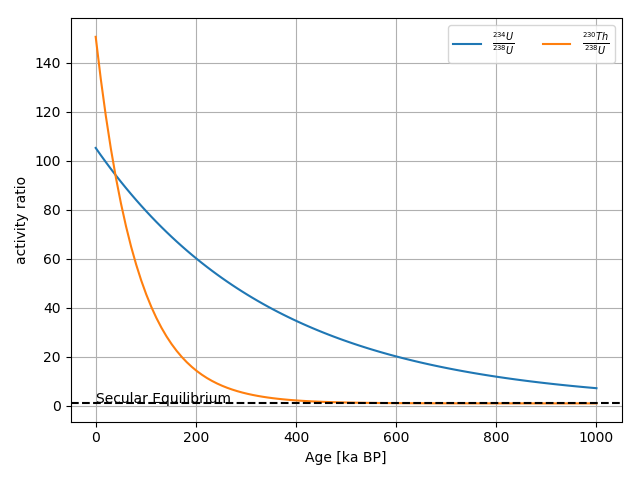

In [21]:
# get the samples initial 234/238 activity ratio from the output of U_Th_inverse class' age calculations

age = ages.iter_age_corr().age_corr[0]
age_e = ages.iter_age_e()
gamma_0 = ages.delta_to_A(ages.d234U_i(age, age_e)[0])[0]


smpl_fwd = U_Th_forward(gamma_0)
smpl_fwd.plot()